# Imports

In [93]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime

# Helper functions

In [94]:
conversion_rates = {
    'CHF': 1.14,  # 1 CHF = 1.134556 USD as of Feb 20, 2024, according to X-Rates
    'TRY': 0.032,   # 1 TRY = 0.03230 USD as of Feb 21, 2024, according to Wise
    'PLN': 0.25,  # 1 PLN = 0.250338 USD as of Feb 21, 2024, according to Xe.com
    'GBP': 1.26,      # Example rate, adjust with the actual rate when available
    'JOD': 1.41,      # Example rate, adjust with the actual rate when available
    'AUD' : 0.66,
    'BRL' : 0.2,
    'IDR' : 0.000064,
    'USD' : 1.0,
    'EUR' : 1.08,
    'ALL' : 0.010,
    'JPY' : 0.0066,
    'BDT' : 0.0091,

}



In [95]:
def convert_to_usd(row, price_col_name, currency_col_name):
    price = row[price_col_name]
    currency = row[currency_col_name]
    price = row['ticket_price']
    conversion_rate = conversion_rates.get(currency)

    # Check if conversion_rate is None
    if conversion_rate is None:
        # Handle the error (e.g., return 0, raise an exception, or use a default conversion rate)
        raise ValueError(f"Conversion rate for currency '{currency}' is not available.")
        # Alternatively, you can return 0 or some default value instead of raising an error
        # return 0
    
    return price * conversion_rate


In [96]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(fifth_element)
            else:
                try:
                    cleaned_lst.append(int(fifth_element))
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(0)
        else:
            cleaned_lst.append(0)  # If the list is too short, consider the fifth element as 0
    return cleaned_lst



In [97]:
def convert_list_to_datetime(date_list):
    # Convert 'null' strings to 0 and other elements to integers
    date_list = [0 if element == 'null' else int(element) for element in date_list]
    
    try:
        if len(date_list) == 5:
            # If all components are present, unpack the list directly into datetime
            return datetime(*date_list)
        elif len(date_list) == 4:
            # If the minute is missing (or any single component), append 0 for minutes and then convert
            return datetime(*(date_list + [0]))
        else:
            # Return None for lists of unexpected length to indicate an issue
            return None
    except TypeError:
        # Handle cases where the list contents cannot be directly unpacked into datetime
        return None




In [98]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(item[:4] + [fifth_element] + item[5:])
            else:
                try:
                    cleaned_lst.append(item[:4] + [int(fifth_element)] + item[5:])
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(item[:4] + [0] + item[5:])
        else:
            # If the list is too short, consider the fifth element as 0
            cleaned_lst.append(item[:4] + [0])
    return cleaned_lst



# Read and Clean Dataset

In [99]:
df = pd.read_csv('../data/query_results/Query4_results_test.csv')

In [100]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(ast.literal_eval)

In [101]:
df['arrival_date'] = clean_fifth_element(df['arrival_date'])
df['departure_date'] = clean_fifth_element(df['departure_date'])

In [102]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(convert_list_to_datetime)

**Create identifier (FlightID) for identical flights**

In [103]:
df['Flight_ID'] = df[['airline_code', 'departure_airport_code', 'destination_airport_code','First_flight','last_flight_code','arrival_date','departure_date', 'departure_time','selling_airline','arrival_time','first_flight_code']].astype(str).agg('-'.join, axis=1)

In [104]:
df = df.drop(['departure_time','selling_airline','arrival_time'], axis = 1)

**Remove duplicates**

In [105]:
df["Duplicate_checker"] = df['Flight_ID'] + df['Detected_Country'] + df["Detected_Language"] + df["Detected_Country"] + str(df["ticket_price"])

In [106]:
df_reduced = df.drop_duplicates(subset='Duplicate_checker', keep='first').copy()

In [107]:
df_reduced = df_reduced.drop(['Duplicate_checker'], axis = 1)

**Remove NaN and erroneous rows**

In [108]:
df_reduced.dropna(subset=['Detected_Currency', 'ticket_price', 'Detected_Country'], inplace=True)

In [109]:
df_reduced = df_reduced[df_reduced['ticket_price'] >= 10]

# Feature engineering

In [110]:
df_reduced['Price_in_USD'] = df_reduced.apply(lambda row: convert_to_usd(row, 'ticket_price', 'Detected_Currency'), axis=1)

Creating commutime time

In [111]:
df_reduced['commute_time'] = (df_reduced['arrival_date'] - df_reduced['departure_date']).dt.total_seconds() / 60

In [112]:
df_reduced['query_date'] = pd.Timestamp('2024-02-15')

In [113]:
df_reduced['days_until_departure'] = (df_reduced['departure_date'] - df_reduced['query_date']).dt.days

**Eliminating queries with little country variance**

In [114]:
# Count the number of different countries available per Flight_ID
country_count_per_flight = df_reduced.groupby('Flight_ID')['Detected_Country'].nunique().reset_index(name='FlightID_in_Countries_Count')

# Merge this count back into the original dataframe
df_reduced = df_reduced.merge(country_count_per_flight, on='Flight_ID')


In [115]:
df_reduced = df_reduced[df_reduced['FlightID_in_Countries_Count'] >= 8]

**Creating Journey_ID: Identifier for identical journeys (same departure and destination airport) on same days**

Extracting departure and arrival days

In [116]:
df_reduced["departure_date_day"] = df_reduced["departure_date"].dt.strftime('%d-%m-%Y')
df_reduced["arrival_date_day"] = df_reduced["arrival_date"].dt.strftime('%d-%m-%Y')

Creating column for whole Journey

In [117]:
df_reduced["Journey_route"] = df_reduced["departure_airport_code"] + "-" + df_reduced["destination_airport_code"]

In [118]:
df_reduced["Journey_ID"] = df_reduced["Journey_route"] + ": " + df_reduced["departure_date_day"] + " "  + df_reduced["arrival_date_day"]

**Creating Variables that analyse price differences between identical Flights**

In [119]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats = df_reduced.groupby('Flight_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats['max_abs_diff_perIDGroup'] = price_stats['max'] - price_stats['min']

# Calculate the relative difference as a percentage of the min price
price_stats['max_rel_diff_perIDGroup'] = (price_stats['max_abs_diff_perIDGroup'] / price_stats['min']) * 100

In [120]:
df_reduced = pd.merge(df_reduced, price_stats, on='Flight_ID', how='left')

In [121]:
df_reduced["abs_diff_to_min"] = df_reduced["Price_in_USD"] - df_reduced["min"]
df_reduced["rel_diff_to_min"] = ((df_reduced["Price_in_USD"] /df_reduced["min"] ) -1) * 100
df_reduced['price_score_perIDGroup'] = df_reduced['rel_diff_to_min'] / df_reduced['max_rel_diff_perIDGroup']

**Creating Variables that analyse price differences between identical Journey**

In [122]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats_journey = df_reduced.groupby('Journey_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats_journey['max_abs_diff_perIDGroup_Journey'] = price_stats_journey['max'] - price_stats_journey['min']
price_stats_journey.columns = ['max_journey', 'min_journey', 'max_abs_diff_perIDGroup_Journey']
price_stats_journey['max_rel_diff_perIDGroup_Journey'] = (price_stats_journey['max_abs_diff_perIDGroup_Journey'] / price_stats_journey['min_journey']) * 100

In [123]:
price_stats_journey

,max_journey,min_journey,max_abs_diff_perIDGroup_Journey,max_rel_diff_perIDGroup_Journey
Journey_ID,,,,
BWI-LUX: 26-02-2024 27-02-2024,4064.94,3515.2500,549.6900,15.637295
CAN-MUC: 31-05-2024 01-06-2024,3043.26,1397.4900,1645.7700,117.766138
CAN-MUC: 31-05-2024 31-05-2024,4811.40,1146.4300,3664.9700,319.685458
CGK-JFK: 15-07-2024 15-07-2024,2602.38,1208.5200,1393.8600,115.336114
CGK-JFK: 15-07-2024 16-07-2024,2457.84,1353.9100,1103.9300,81.536439
...,...,...,...,...
VIE-LED: 15-04-2024 16-04-2024,1391.94,648.9318,743.0082,114.497117
ZAG-LIM: 19-12-2024 19-12-2024,2704.68,2585.3100,119.3700,4.617241
ZAG-LIM: 19-12-2024 20-12-2024,2678.28,2559.6200,118.6600,4.635844


In [124]:
df_reduced = pd.merge(df_reduced, price_stats_journey, on='Journey_ID', how='left')

In [125]:
df_reduced["abs_diff_to_min_Journey"] = df_reduced["Price_in_USD"] - df_reduced["min_journey"]
df_reduced["rel_diff_to_min_Journey"] = ((df_reduced["Price_in_USD"] /df_reduced["min_journey"] ) -1) * 100
df_reduced['price_score_perIDGroup_Journey'] = df_reduced['rel_diff_to_min_Journey'] / df_reduced['max_rel_diff_perIDGroup_Journey']

In [126]:
df_reduced.max_rel_diff_perIDGroup_Journey.mean()

182.5517675268012

**Creating Variables that analyse price differences between identical Journey within the same query-country**

In [127]:
price_stats_journey_same_country = df_reduced.groupby(['Journey_ID', 'Detected_Country'])['Price_in_USD'].agg(['max', 'min'])
price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] = price_stats_journey_same_country['max'] - price_stats_journey_same_country['min']
price_stats_journey_same_country.columns = ['max_journey_same_country', 'min_journey_same_country', 'max_abs_diff_perIDGroup_Journey_same_country']
price_stats_journey_same_country['max_rel_diff_perIDGroup_Journey_same_country'] = (price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

In [128]:
price_stats_journey_same_country

max_journey_same_country  \
Journey_ID                     Detected_Country                             
BWI-LUX: 26-02-2024 27-02-2024 Australia                      4064.940000   
                               Brasil                         4004.600000   
                               Deutschland                    4032.720000   
                               Indonesia                      4044.615232   
                               Polska                         4032.750000   
...                                                                   ...   
ZAG-NRT: 05-11-2024 07-11-2024 Polska                         1022.000000   
                               Schweiz                        1029.420000   
                               Shqipëri                        985.100000   
                               Türkiye                        1020.416000   
                               বাংলাদেশ                       1023.922900   

                                                 min_journey_same_country  \
Journey_ID                     Detected_Country                             
BWI-LUX: 26-02-2024 27-02-2024 Australia                       3678.18000   
                               Brasil                          3623.20000   
                               Deutschland                     3649.32000   
                               Indonesia                       3659.44608   
                               Polska                          3648.75000   
...                                                                   ...   
ZAG-NRT: 05-11-2024 07-11-2024 Polska                          1022.00000   
                               Schweiz                         1029.42000   
                               Shqipëri                         985.10000   
                               Türkiye                         1020.41600   
                               বাংলাদেশ                        1023.92290   

                                                 max_abs_diff_perIDGroup_Journey_same_country  \
Journey_ID                     Detected_Country                                                 
BWI-LUX: 26-02-2024 27-02-2024 Australia                                           386.760000   
                               Brasil                                              381.400000   
                               Deutschland                                         383.400000   
                               Indonesia                                           385.169152   
                               Polska                                              384.000000   
...                                                                                       ...   
ZAG-NRT: 05-11-2024 07-11-2024 Polska                                                0.000000   
                               Schweiz                                               0.000000   
                               Shqipëri                                              0.000000   
                               Türkiye                                               0.000000   
                               বাংলাদেশ                                              0.000000   

                                                 max_rel_diff_perIDGroup_Journey_same_country  
Journey_ID                     Detected_Country                                                
BWI-LUX: 26-02-2024 27-02-2024 Australia                                            10.514983  
                               Brasil                                               10.526606  
                               Deutschland                                          10.506067  
                               Indonesia                                            10.525340  
                               Polska                                               10.524152  
...                                                                                       ...  
ZAG-NRT: 05-11-

In [129]:
df_reduced = pd.merge(df_reduced, price_stats_journey_same_country, on=['Journey_ID','Detected_Country'], how='left')

In [130]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

In [131]:
df_reduced["price_diff_loc_to_glob_Journey_min"] = df_reduced["min_journey_same_country"] - df_reduced["min_journey"]

In [132]:
df_reduced["rel_price_diff_loc_to_glob_Journey_min"] = (df_reduced["price_diff_loc_to_glob_Journey_min"] / df_reduced["min_journey"]) * 100

In [134]:
df_reduced.rel_price_diff_loc_to_glob_Journey_min.mean()

4.509578187892165

In [136]:
# Group by 'Detected_Country' and calculate the mean of 'rel_price_diff_loc_to_glob_Journey_min'
grouped_means = df_reduced.groupby('Detected_Country')['rel_price_diff_loc_to_glob_Journey_min'].mean()

# Display the result
print(grouped_means)


Detected_Country
Australia              7.035948
Brasil                 3.084377
Deutschland            3.859205
Indonesia              3.959648
Palestine              4.120533
Polska                 3.835188
Schweiz                4.383528
Shqipëri               0.358481
Türkiye                3.597201
United Kingdom         7.392782
Vereinigte Staaten     4.479632
বাংলাদেশ               3.802642
日本                    17.559797
Name: rel_price_diff_loc_to_glob_Journey_min, dtype: float64


In [42]:
(price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

Journey_ID                      Detected_Country
AMS-MSP: 27-11-2024 27-11-2024  Brasil              18.229855
                                Deutschland          0.606673
                                Indonesia           18.230197
                                Polska              18.209515
                                Schweiz             18.259023
                                                      ...    
ZAG-NRT: 05-11-2024 07-11-2024  Polska               0.000000
                                Schweiz              0.000000
                                Shqipëri             0.000000
                                Türkiye              0.000000
                                বাংলাদেশ             0.000000
Length: 1009, dtype: float64

In [43]:
df_reduced.Price_in_USD.mean()

1511.3457881118532

In [44]:
df_reduced.price_diff_loc_to_glob_Journey_min.median()

20.389999999999986

In [45]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Flight_ID
cheapest_mask_journey = df_reduced['Price_in_USD'] == df_reduced['min_journey']
cheapest_journeys = df_reduced[cheapest_mask_journey]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations_journey = cheapest_journeys.groupby('Journey_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations_journey.rename(columns={'Detected_Country': 'Cheapest_Location_Journey'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations_journey, on='Journey_ID', how='left')


In [46]:
df_reduced.head()

,airline_code,departure_airport_code,destination_airport_code,ticket_price,departure_date,arrival_date,First_flight,first_flight_code,last_flight_code,Detected_Language,...,abs_diff_to_min_Journey,rel_diff_to_min_Journey,price_score_perIDGroup_Journey,max_journey_same_country,min_journey_same_country,max_abs_diff_perIDGroup_Journey_same_country,max_rel_diff_perIDGroup_Journey_same_country,price_diff_loc_to_glob_Journey_min,rel_price_diff_loc_to_glob_Journey_min,Cheapest_Location_Journey
0,AA,CLT,CUN,383,2024-06-26 07:15:00,2024-06-26 09:10:00,CLT-CUN,AA881,AA881,Deutsch,...,16.28,4.097040,0.065677,641.52,413.64,227.88,55.091384,16.28,4.09704,Shqipëri
1,AA,CLT,CUN,383,2024-06-26 11:50:00,2024-06-26 13:54:00,CLT-CUN,AA886,AA886,Deutsch,...,16.28,4.097040,0.065677,641.52,413.64,227.88,55.091384,16.28,4.09704,Shqipëri
2,AA,CLT,CUN,383,2024-06-26 13:05:00,2024-06-26 14:59:00,CLT-CUN,AA1778,AA1778,Deutsch,...,16.28,4.097040,0.065677,641.52,413.64,227.88,55.091384,16.28,4.09704,Shqipëri
3,AA,CLT,CUN,410,2024-06-26 09:05:00,2024-06-26 11:13:00,CLT-CUN,AA895,AA895,Deutsch,...,45.44,11.435474,0.183315,641.52,413.64,227.88,55.091384,16.28,4.09704,Shqipëri
4,UA,CLT,CUN,401,2024-06-26 10:07:00,2024-06-26 15:51:00,CLT-IAD,UA1361,UA1618,Deutsch,...,35.72,8.989330,0.144102,641.52,413.64,227.88,55.091384,16.28,4.09704,Shqipëri


In [47]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Flight_ID
cheapest_mask = df_reduced['Price_in_USD'] == df_reduced['min']
cheapest_flights = df_reduced[cheapest_mask]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations = cheapest_flights.groupby('Flight_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations.rename(columns={'Detected_Country': 'Cheapest_Location_Flight'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations, on='Flight_ID', how='left')


In [48]:
df_reduced.Cheapest_Location_Flight.value_counts()

Cheapest_Location_Flight
Shqipëri          3689
Brasil             740
Polska             180
日本                 111
Türkiye             57
United Kingdom      15
Name: count, dtype: int64

# Descriptive Statistics

**_These countries are connected with higher Prices for identical flights_**

In [49]:
temp_df_exp = df_reduced[df_reduced['price_score_perIDGroup'] > 0.8]
temp_df_exp.Detected_Country.value_counts()

Detected_Country
Schweiz               534
Indonesia             416
Polska                405
Deutschland           332
Australia             284
বাংলাদেশ              277
Türkiye               201
Palestine             102
United Kingdom         95
Vereinigte Staaten     73
Brasil                  5
Kıbrıs                  4
日本                      2
Name: count, dtype: int64

**_These countries are connected with lower prices for identical flights_**

In [50]:
temp_df_cheap = df_reduced[(df_reduced['max_rel_diff_perIDGroup'] > 4) & (df_reduced['price_score_perIDGroup'] < 0.2)]
temp_df_cheap.Detected_Country.value_counts()

Detected_Country
Shqipëri          484
Polska              9
Türkiye             8
Brasil              8
বাংলাদেশ            8
Indonesia           6
Schweiz             6
Deutschland         4
United Kingdom      1
日本                  1
Australia           1
Name: count, dtype: int64

Distribution shows tendency of having more "expensive" flights (flights close to max-price) and less variation in general

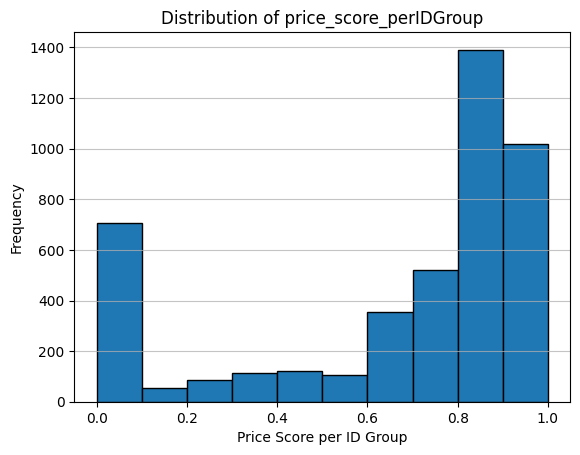

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_reduced is your DataFrame
# Plotting the histogram
df_reduced['price_score_perIDGroup'].plot.hist(bins=10, range=(0, 1), edgecolor='black')

plt.title('Distribution of price_score_perIDGroup')
plt.xlabel('Price Score per ID Group')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for better readability

plt.show()

** Average indicates that the average maximum relative difference increases with Price**

In [52]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

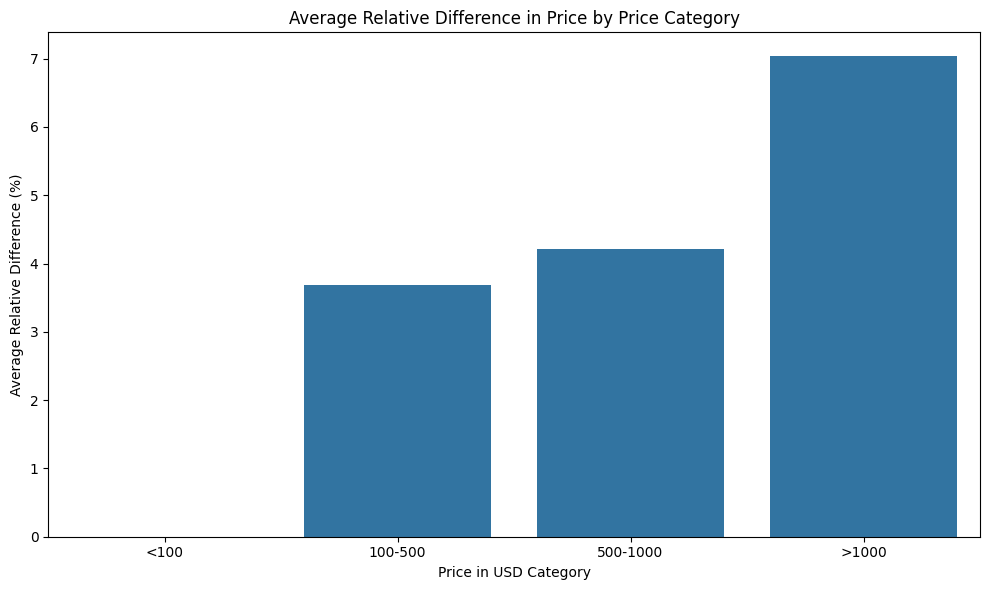

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_diff_perIDGroup')
plt.title('Average Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


** Median doesnt show this effect **

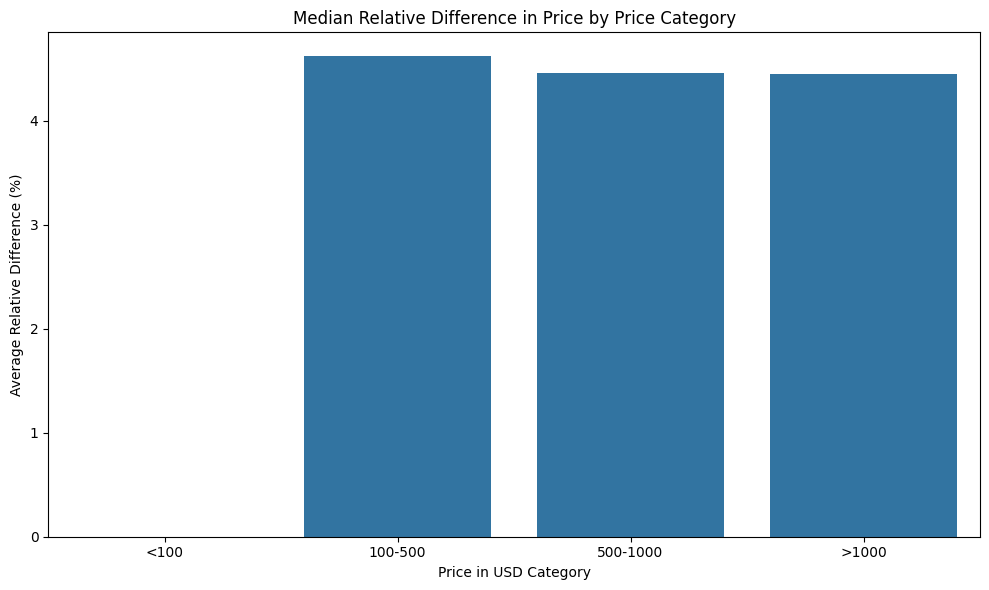

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_diff_perIDGroup'].median().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_diff_perIDGroup')
plt.title('Median Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()

**The average price spread grows with commute time**

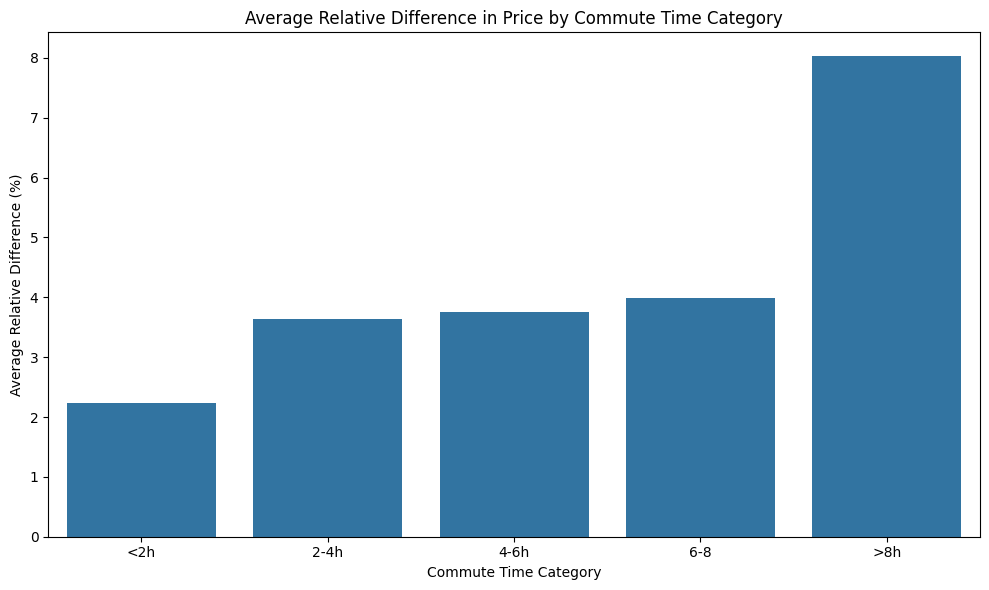

In [55]:
# Adjust bins based on the new categories in minutes
bins = [-float('inf'), 120, 240, 480,750, float('inf')]
labels = ['<2h', '2-4h', '4-6h','6-8' ,'>8h']

# Bin 'commute_time' into categories directly, no need to convert to hours since it's already in minutes
df_reduced['Commute_Time_Category'] = pd.cut(df_reduced['commute_time'], bins=bins, labels=labels)

# Group by the new 'Commute_Time_Category' and calculate the mean 'max_rel_diff_perIDGroup' for each category
avg_rel_diff_by_commute_cat = df_reduced.groupby('Commute_Time_Category', observed = True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Plotting the average relative difference by commute time category
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_commute_cat, x='Commute_Time_Category', y='max_rel_diff_perIDGroup')
plt.title('Average Relative Difference in Price by Commute Time Category')
plt.xlabel('Commute Time Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


**Most Airlines seem to have an average price-spread in between of 3.5 and 4.5**

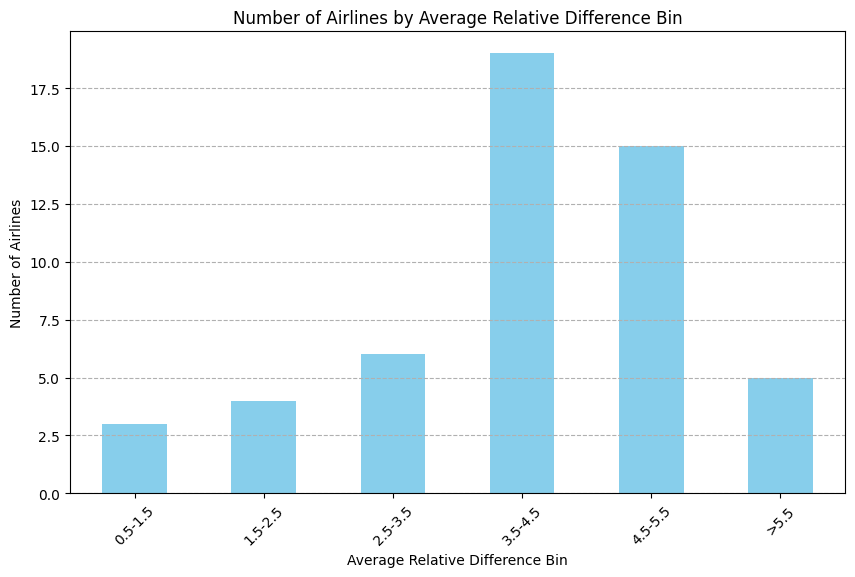

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the conditional mean of 'rel_diff' for each airline
avg_rel_diff_per_airline = df_reduced.groupby('airline_code', observed=True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Define bins and labels for the categorized means
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, float('inf')]
labels = [ '0.5-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.5', '>5.5']

# Step 2: Categorize these averages into the specified bins
avg_rel_diff_per_airline['avg_rel_diff_bin'] = pd.cut(avg_rel_diff_per_airline['max_rel_diff_perIDGroup'], bins=bins, labels=labels)

# Step 3: Count how many airlines fall into each bin
airlines_per_bin = avg_rel_diff_per_airline['avg_rel_diff_bin'].value_counts().sort_index()

# Plotting the result
airlines_per_bin.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Airlines by Average Relative Difference Bin')
plt.xlabel('Average Relative Difference Bin')
plt.ylabel('Number of Airlines')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


**Which airlines change their prices based on location**

In [57]:
# Group airlines by their average 'rel_diff' bin
grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)

# Convert to a DataFrame for a nicer display, if desired
grouped_airlines_df = grouped_airlines.reset_index().rename(columns={'airline_code': 'Airlines'})


# Display the DataFrame
print(grouped_airlines_df)


  avg_rel_diff_bin                                           Airlines
0          0.5-1.5                                       [NK, TU, VJ]
1          1.5-2.5                                   [AS, EI, TG, XE]
2          2.5-3.5                           [B6, BR, DL, EY, NH, OZ]
3          3.5-4.5  [AA, AF, AV, AY, BA, CZ, ET, KE, LA, LH, LO, M...
4          4.5-5.5  [AM, AZ, CM, CX, F8, F9, JL, KL, LX, OS, SK, U...
5             >5.5                               [AC, EK, IB, QR, UA]


/var/folders/fs/20409g9545qdjn0qhsrcd8q80000gn/T/ipykernel_37947/811506572.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)


In [58]:
avg_rel_diff_per_airline

,airline_code,max_rel_diff_perIDGroup,avg_rel_diff_bin
0,AA,4.355316,3.5-4.5
1,AC,14.731301,>5.5
2,AF,4.239161,3.5-4.5
3,AM,4.637533,4.5-5.5
4,AS,2.468050,1.5-2.5
5,AV,4.488944,3.5-4.5
6,AY,4.496096,3.5-4.5
7,AZ,4.604290,4.5-5.5
8,B6,3.134127,2.5-3.5
9,BA,3.817349,3.5-4.5


Which countries are the cheapest?

In [59]:
cheap_df = df_reduced[(df_reduced['min'] == df_reduced['Price_in_USD'] )]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = cheap_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Shqipëri          487
Brasil            107
Polska             30
日本                 15
Türkiye            10
United Kingdom      2
Name: count, dtype: int64


**Which countries are more expensive**

In [60]:

expensive_df = df_reduced[(df_reduced['max'] == df_reduced['Price_in_USD'])]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = expensive_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Schweiz               313
Australia             251
Indonesia              53
Vereinigte Staaten     17
Palestine              15
Deutschland             2
United Kingdom          1
Polska                  1
Name: count, dtype: int64


In [61]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

In [62]:
from scipy.stats import kruskal
import pandas as pd

# Assuming df_reduced exists and has 'departure_airport_code' and 'rel_diff'

# Group data by 'departure_airport_code' and extract 'rel_diff' values
groups = df_reduced.groupby('departure_airport_code')['max_rel_diff_perIDGroup'].apply(list)

# Perform Kruskal-Wallis H-test
stat, p = kruskal(*groups)

print(f'Statistic: {stat}, P-value: {p}')

# Interpret the results
alpha = 0.05  # Set a significance level
if p < alpha:
    print("Reject the null hypothesis - suggest the median 'rel_diff' differs across departure airports.")
else:
    print("Fail to reject the null hypothesis - no evidence that the median 'rel_diff' differs across departure airports.")


Statistic: 2767.581632591168, P-value: 0.0
Reject the null hypothesis - suggest the median 'rel_diff' differs across departure airports.


# Statistical Testing

In [63]:
from scipy.stats import f_oneway

# Assuming 'flight_data' is your DataFrame containing flight information
# 'Price' is the column containing flight prices, and 'Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries.")


ANOVA results:
F-statistic: 2507.456455184362
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries.


In [64]:
from scipy.stats import f_oneway

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Assigned_Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries for the same flight route.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries for the same flight route.")


ANOVA results:
F-statistic: 2507.456455184362
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries for the same flight route.


In [65]:
from scipy.stats import ttest_rel

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Flight_ID' is the column containing flight identifiers

# Group the data by Flight_ID and calculate the maximum and minimum prices for each group
max_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].max()
min_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].min()

# Perform paired samples t-test
t_statistic, p_value = ttest_rel(max_prices, min_prices)

# Interpret the results
alpha = 0.05  # Significance level
print("Paired samples t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.")
else:
    print("There is no statistically significant difference between the maximum and minimum prices of each Flight_ID.")


Paired samples t-test results:
t-statistic: 8.469501196061369
p-value: 1.641996215865534e-16
There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.


In [66]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure']], drop_first=True)
y = pd.get_dummies(df_reduced['Cheapest_Location_Journey'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=41)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R² score: {r2_score(y_test, y_pred)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")


R² score: 0.783612019045469
Mean squared error: 0.004884741033939683


In [68]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

In [69]:
# Calculate the mean of max_rel_diff_perIDGroup for each Flight_ID
grouped_means = df_reduced.groupby('FlightID_in_Countries_Count')['rel_price_diff_loc_to_glob_Journey_min'].mean()

In [70]:
grouped_means

FlightID_in_Countries_Count
5      2.229581
6      2.585136
7      2.598715
8      3.316337
9      7.284368
10     5.933292
11    18.155912
Name: rel_price_diff_loc_to_glob_Journey_min, dtype: float64

In [71]:
df_reduced.FlightID_in_Countries_Count.value_counts()

FlightID_in_Countries_Count
8     1136
7     1085
6      876
9      729
10     650
5      305
11      11
Name: count, dtype: int64

In [72]:
df_reduced.max_rel_diff_perIDGroup.max()

257.6895650106965

In [73]:
df_reduced.Price_in_USD.value_counts()

Price_in_USD
124.7500     7
125.2800     7
120.1300     6
124.7400     6
126.5400     6
            ..
3444.3591    1
3597.0298    1
3796.1287    1
4264.2509    1
124.2450     1
Name: count, Length: 3803, dtype: int64

In [74]:
df_reduced.iloc[139:142]

,airline_code,departure_airport_code,destination_airport_code,ticket_price,departure_date,arrival_date,First_flight,first_flight_code,last_flight_code,Detected_Language,...,max_journey_same_country,min_journey_same_country,max_abs_diff_perIDGroup_Journey_same_country,max_rel_diff_perIDGroup_Journey_same_country,price_diff_loc_to_glob_Journey_min,rel_price_diff_loc_to_glob_Journey_min,Cheapest_Location_Journey,Cheapest_Location_Flight,Price_Category,Commute_Time_Category
139,AA,BWI,LIM,4787,2024-11-04 06:48:00,2024-11-04 17:55:00,BWI-CLT,AA2758,AA1307,Português (Brasil),...,1326.4,417.8,908.6,217.472475,12.61,3.11212,Shqipëri,Shqipëri,500-1000,6-8
140,UA,BWI,LIM,5649,2024-11-04 08:15:00,2024-11-04 23:55:00,BWI-IAH,UA2128,UA854,Português (Brasil),...,1326.4,417.8,908.6,217.472475,12.61,3.11212,Shqipëri,Shqipëri,>1000,>8h
141,UA,BWI,LIM,6632,2024-11-04 10:45:00,2024-11-04 23:55:00,BWI-ORD,UA455,UA854,Português (Brasil),...,1326.4,417.8,908.6,217.472475,12.61,3.11212,Shqipëri,Shqipëri,>1000,>8h


In [75]:
df_reduced.FlightID_in_Countries_Count.value_counts()

FlightID_in_Countries_Count
8     1136
7     1085
6      876
9      729
10     650
5      305
11      11
Name: count, dtype: int64

In [76]:
grouped_means

FlightID_in_Countries_Count
5      2.229581
6      2.585136
7      2.598715
8      3.316337
9      7.284368
10     5.933292
11    18.155912
Name: rel_price_diff_loc_to_glob_Journey_min, dtype: float64

In [77]:
# Calculate the mean of max_rel_diff_perIDGroup for each Flight_ID
grouped_means = df_reduced.groupby('airline_code')['max_rel_diff_perIDGroup'].mean()


In [78]:
grouped_means.count()

52

In [79]:
grouped_means.sort_values(ascending=False)

airline_code
UA       18.025831
AC       14.731301
QR       10.213291
EK        6.289316
IB        5.766324
KL        5.239135
VY        5.083260
LX        4.881966
WK        4.766589
UX        4.719420
W4        4.638016
AM        4.637533
CX        4.632271
JL        4.631234
AZ        4.604290
F9        4.552570
CM        4.542145
F8        4.526132
OS        4.510832
SK        4.500885
AY        4.496096
AV        4.488944
LA        4.473724
WS        4.462403
TP        4.454339
LO        4.448080
CZ        4.439247
MU        4.437497
multi     4.399067
AA        4.355316
TK        4.300222
AF        4.239161
PC        4.111757
ET        4.108390
BA        3.817349
KE        3.685751
SQ        3.649837
LH        3.608504
MS        3.515535
OZ        3.435653
DL        3.264153
NH        3.198602
B6        3.134127
EY        2.721481
BR        2.550810
AS        2.468050
EI        2.339673
TG        2.161548
XE        1.517413
NK        1.236773
VJ        0.857685
TU        0.726877

In [80]:
grouped_means.head()

airline_code
AA     4.355316
AC    14.731301
AF     4.239161
AM     4.637533
AS     2.468050
Name: max_rel_diff_perIDGroup, dtype: float64

In [81]:
df_reduced.max_rel_diff_perIDGroup.median()

4.461800185586128

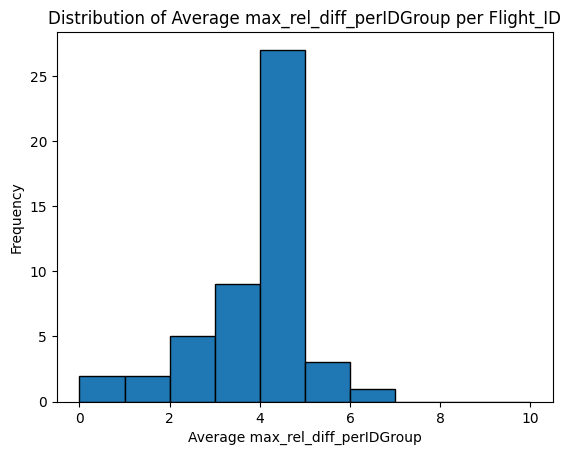

In [82]:
import matplotlib.pyplot as plt

# Plotting the histogram of the aggregated means
plt.hist(grouped_means, bins=10, range=(0, 10), edgecolor='black')
plt.title('Distribution of Average max_rel_diff_perIDGroup per Flight_ID')
plt.xlabel('Average max_rel_diff_perIDGroup')
plt.ylabel('Frequency')
plt.show()


In [91]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

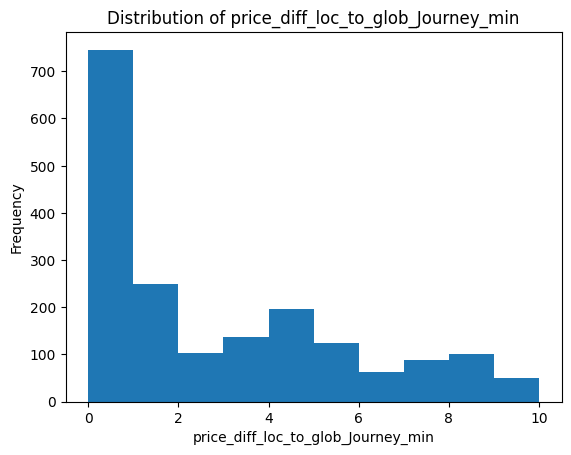

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting directly from the DataFrame
df_reduced['price_diff_loc_to_glob_Journey_min'].hist(bins=10, range=(0, 10))

plt.title('Distribution of price_diff_loc_to_glob_Journey_min')
plt.xlabel('price_diff_loc_to_glob_Journey_min')
plt.ylabel('Frequency')
plt.grid(False)  # Optionally disable the grid for a cleaner look
plt.show()


In [87]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'max_journey', 'min_journey',
       'max_abs_diff_perIDGroup_Journey', 'max_rel_diff_perIDGroup_Journey',
       'abs_diff_to_min_Journey', 'rel_diff_to_min_Journey',
       'price_score_perIDGroup_Journey', 'max_journey_same_country',
       'min_journey_same_country',
       'max_abs_diff_perIDGroup_Journey_same_country',
       'max_rel_diff_perIDGroup_Journey_same_country

In [90]:
from scipy.stats import ttest_1samp
import numpy as np

# Assuming df_reduced is your DataFrame and max_rel_diff_perIDGroup is the column you're testing
data = df_reduced['rel_price_diff_loc_to_glob_Journey_min'].dropna()  # Drop NaN values if any

# Perform the one-sample t-test against the null hypothesis that the mean is 0
t_statistic, p_value = ttest_1samp(data, 0)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.01:
    print("We reject the null hypothesis. The mean of max_rel_diff_perIDGroup is significantly different from 0.")
else:
    print("We fail to reject the null hypothesis. There is not enough evidence to say the mean of max_rel_diff_perIDGroup is significantly different from 0.")


T-statistic: 14.811658019146654
P-value: 1.441155962821771e-48
We reject the null hypothesis. The mean of max_rel_diff_perIDGroup is significantly different from 0.


In [86]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming df_reduced is your DataFrame and it's already loaded

# Prepare your data: Get dummies for categorical variables
X = pd.get_dummies(df_reduced[['airline_code', 'Price_in_USD', 'Detected_Country', 'First_flight']], drop_first=True)
y = df_reduced['max_rel_diff_perIDGroup']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Lasso regression model
# alpha is the regularization strength; larger values specify stronger regularization.
lasso_model = Lasso(alpha=0.1)  # You might need to adjust the alpha value

# Fit the Lasso model to the training data
lasso_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
print(f"R² score: {r2_score(y_test, y_pred)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")

# Viewing the coefficients
coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
print("Coefficients:")
print(coefficients)


R² score: 0.87621996714408
Mean squared error: 31.10233290195303
Coefficients:
Price_in_USD            0.000097
airline_code_AC         0.000000
airline_code_AF        -0.000000
airline_code_AM         0.000000
airline_code_AS        -0.000000
                          ...   
First_flight_ZAG-IST   -0.000000
First_flight_ZAG-LHR   -0.000000
First_flight_ZAG-MUC   -0.000000
First_flight_ZAG-VIE    0.000000
First_flight_ZAG-WAW   -0.000000
Length: 387, dtype: float64
